# **Start doing <span style="color:goldenrod">your own</span> Python Modules &#x1F4AB;**

At the end of this PyCoffee, you'll finally understand those strange:
- ```if __name__ = '__main__'```
- ```__init__.py```

## **When and why** should I create Modules?

### __1.__ **Terminal**: For fast and puntual tasks.

What is the JD of a particular date?

In [1]:
from astropy.time import Time
import numpy as np

t_pycoffee = '2024-03-06T09:30:00' # this is the date I want to translate into jd
jd_pycoffee = Time(t_pycoffee, format = 'isot', scale = 'utc').jd

print(f'The PyCoffee is at JD = {np.round(jd_pycoffee, 1)}!')

The PyCoffee is at JD = 2460375.9!


### __2.__  **Scripts or Notebooks**: Repetitive tasks or longer codes.

What is the twilight for a given location and date?

In [2]:
import astropy
from astropy.coordinates import EarthLocation, AltAz, get_sun
from astropy.time import Time
import astropy.units as u


# -- Functions --
def range_tw(jd_arr, location, which_tw = 'both'):

    alt_astronomical_tw = -18 # deg

    range_tw_mo = []
    range_tw_ev = []
    for step,jdi in enumerate(jd_arr):
        time_format = Time(jdi, format = 'jd', scale = 'utc')
        sun_coord = get_sun(time_format).transform_to(AltAz(obstime = time_format, location = location)) # Alt, Az coordinates of the sun
        sun_alt = sun_coord.alt.value
        dif = sun_alt - alt_astronomical_tw
        if step == 0:
            prev_dif = dif
            continue # in the first step we just need to define the variable 'prev_dif' and the we continue with the 'for' loop
        if dif * prev_dif < 0: # check if there is a change in the sign of 'dif' in this step
            if dif > 0: # the altitude of the sun is increasing and therefore this is the morning twilight
                range_tw_mo = [jd_arr[step - 1], jdi]
            else: # the altitude of the sun is decreasing and therefore this is the evening twilight
                range_tw_ev = [jd_arr[step - 1], jdi]

        # check if the target twilight has been found. If so, there is no need to continue the loop
        if (len(range_tw_mo) != 0) and (len(range_tw_ev) != 0) and (which_tw == 'both'):
            break
        elif (len(range_tw_mo) != 0) and (which_tw == 'mo'):
            break
        elif (len(range_tw_ev) != 0) and (which_tw == 'ev'):
            break
        
        prev_dif = dif # redifine for the next step

    return range_tw_mo, range_tw_ev


def compute_tw(date, lat, long, alt): # the date must be in format 'Y/M/D'
    
    location = EarthLocation(lat = lat * u.deg, lon = long * u.deg, height = alt * u.m)

    # first approximation of the twilightls by using big steps of 1 h
    jd_init = Time(date + 'T00:00:00', scale = 'utc', format = 'isot').jd # beginning of the day
    jd_end = jd_init + 1.0 # end of the day
    jd_h_step = np.linspace(jd_init, jd_end, 25)
    range_tw_mo, range_tw_ev = range_tw(jd_h_step, location)

    # we fine tune the twilightls by using smaller steps of 1 min
    jd_tw_mo_array = np.linspace(range_tw_mo[0], range_tw_mo[1], 61) # array with steps of 1 min
    small_range_tw_mo, _ = range_tw(jd_tw_mo_array, location, which_tw = 'mo')
    tw_mo = np.median(small_range_tw_mo) # as an approximation. The uncertainty is 1 min
    
    jd_tw_ev_array = np.linspace(range_tw_ev[0], range_tw_ev[1], 61) # array with steps of 1 min
    _, small_range_tw_ev = range_tw(jd_tw_ev_array, location, which_tw = 'ev')
    tw_ev = np.median(small_range_tw_ev)

    return tw_mo, tw_ev
#----------------


# ---- Main ----
date = '2024-03-06' 
latitude, longitude, altitude = [40.441401, -3.952766, 665] # Coordinates in units [deg], [deg], [m]

tw_mo, tw_ev = compute_tw(date, latitude, longitude, altitude)
time_tw_ev = Time(tw_ev, format = 'jd').isot
print(f'The evening twilight today at ESAC is at {time_tw_ev[11:16]} UTC')
#----------------

The evening twilight today at ESAC is at 19:43 UTC


### __3.__  **Modules**: Very used codes that we want to use in different scripts.

What is the altitude of *T Dra* during this night as seeing from ESAC?

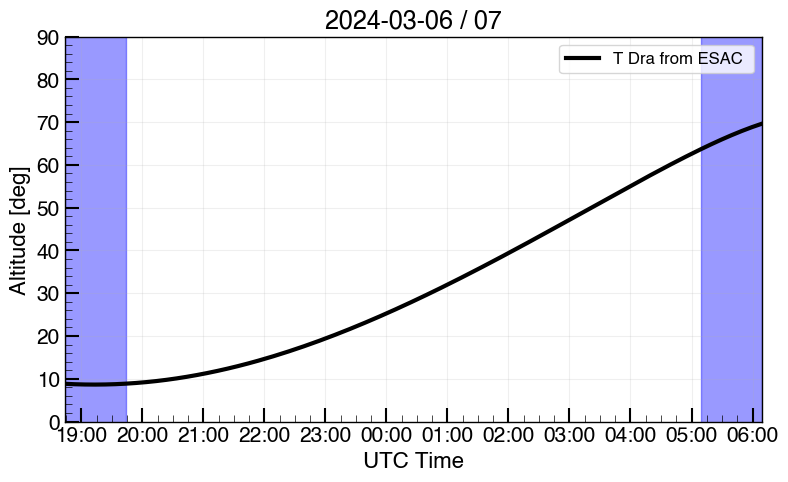

In [3]:
import my_module

# ---------- Date, location and target ----------
date_init = '2024-03-06' # beginning of the night
date_end = '2024-03-07' # end of the night
latitude, longitude, altitude = [40.441401, -3.952766, 665] # Coordinates in units [deg], [deg], [m]
obj_name = 'T Dra'
# -----------------------------------------------

# Twilights, altitude, and plot the star altitude
_, tw_ev = my_module.compute_tw(date_init, latitude, longitude, altitude)
tw_mo, _ = my_module.compute_tw(date_end, latitude, longitude, altitude)

alt_tar = my_module.alt_fromloc_atdate(obj_name, latitude, longitude, altitude, tw_ev, tw_mo)

my_module.do_plot(tw_ev, tw_mo, alt_tar, obj_name, 'ESAC')

**Strong** points of Modules:
- **Organization:** a python script per functionality.
- **Readable**: the hard parts are hidden and logically located.
- **Reusable**: in different scripts.
- **Namespaces**: preventing naming conflicts.

## **Create** the Module

```If modules == script.py:```
>```print("what is new?")```

Indeed, python modules are just scripts.\
The point is to have several scripts that build **packages** (*e.g., tw_calculator.py, target_coord_calculator.py, staralt_plot.py*).\
They have to be stored in a directory, or organized in subdirectories.\
Each script has its own imports, functions and variables.

In this example, the three modules are:

In [4]:
# tw_calculator.py 

import numpy as np
from astropy.coordinates import EarthLocation, AltAz, get_sun
from astropy.time import Time
import astropy.units as u


def range_tw(jd_arr, location, which_tw = 'both'):

    alt_astronomical_tw = -18 # deg

    range_tw_mo = []
    range_tw_ev = []
    for step,jdi in enumerate(jd_arr):
        time_format = Time(jdi, format = 'jd', scale = 'utc')
        sun_coord = get_sun(time_format).transform_to(AltAz(obstime = time_format, location = location)) # Alt, Az coordinates of the sun
        sun_alt = sun_coord.alt.value
        dif = sun_alt - alt_astronomical_tw
        if step == 0:
            prev_dif = dif
            continue # in the first step we just need to define the variable 'prev_dif' and the we continue with the 'for' loop
        if dif * prev_dif < 0: # check if there is a change in the sign of 'dif' in this step
            if dif > 0: # the altitude of the sun is increasing and therefore this is the morning twilight
                range_tw_mo = [jd_arr[step - 1], jdi]
            else: # the altitude of the sun is decreasing and therefore this is the evening twilight
                range_tw_ev = [jd_arr[step - 1], jdi]

        # check if the target twilight has been found. If so, there is no need to continue the loop
        if (len(range_tw_mo) != 0) and (len(range_tw_ev) != 0) and (which_tw == 'both'):
            break
        elif (len(range_tw_mo) != 0) and (which_tw == 'mo'):
            break
        elif (len(range_tw_ev) != 0) and (which_tw == 'ev'):
            break
        
        prev_dif = dif # redifine for the next step

    return range_tw_mo, range_tw_ev


def compute_tw(date, lat, lon, alt): # the date must be in format 'Y/M/D'
    
    location = EarthLocation(lat = lat * u.deg, lon = lon * u.deg, height = alt * u.m)

    # first approximation of the twilightls by using big steps of 1 h
    jd_init = Time(date + 'T00:00:00', scale = 'utc', format = 'isot').jd # beginning of the day
    jd_end = jd_init + 1.0 # end of the day
    jd_h_step = np.linspace(jd_init, jd_end, 25)
    range_tw_mo, range_tw_ev = range_tw(jd_h_step, location)

    # we fine tune the twilightls by using smaller steps of 1 min
    jd_tw_mo_array = np.linspace(range_tw_mo[0], range_tw_mo[1], 61) # array with steps of 1 min
    small_range_tw_mo, _ = range_tw(jd_tw_mo_array, location, which_tw = 'mo')
    tw_mo = np.median(small_range_tw_mo) # as an approximation. The uncertainty is 1 min
    
    jd_tw_ev_array = np.linspace(range_tw_ev[0], range_tw_ev[1], 61) # array with steps of 1 min
    _, small_range_tw_ev = range_tw(jd_tw_ev_array, location, which_tw = 'ev')
    tw_ev = np.median(small_range_tw_ev)

    return tw_mo, tw_ev

In [5]:
# target_coord_calculator.py

from astroquery.simbad import Simbad
from astropy.coordinates import SkyCoord
from astropy import units as u
import numpy as np
from astropy.time import Time
from astropy.coordinates import EarthLocation, AltAz


def alt_fromloc_atdate(obj_name, lat, lon, alt, tw_ev, tw_mo):

    location = EarthLocation(lat = lat * u.deg, lon = lon * u.deg, height = alt * u.m)

    target = Simbad.query_object(obj_name)
    RA, DEC = target['RA'][0], target['DEC'][0]
    coord_tar = SkyCoord(f'{RA} {DEC}', unit = (u.hourangle, u.deg))

    t = np.arange(tw_ev - 1/24, tw_mo + 1/24, step = 5/(24 * 60)) # time array with steps of 5 min with +- 1 h of twilights
    alt_tar = coord_tar.transform_to(AltAz(location = location, obstime = Time(t, format = 'jd'))).alt.value

    return alt_tar

In [6]:
# staralt_plot.py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.ticker import AutoMinorLocator
from astropy.time import Time
import matplotlib.dates as mdates


rcParams['font.size'] = 16.0
rcParams['axes.linewidth'] = 1

rcParams['ytick.major.size'] = 6
rcParams['ytick.major.width'] = 1.5
rcParams['ytick.minor.size'] = 3
rcParams['ytick.minor.width'] = 0.5

rcParams['xtick.major.size'] = 6
rcParams['xtick.major.width'] = 1.5
rcParams['xtick.minor.size'] = 3
rcParams['xtick.minor.width'] = 0.5

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Helvetica']


def do_plot(tw_ev, tw_mo, alt_tar, obj_name, obs_name):

    fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (9, 5))

    # main plot
    x_utc = pd.date_range(start = Time(tw_ev - 1/24, format = 'jd').isot, end = Time(tw_mo + 1/24, format = 'jd').isot, periods = len(alt_tar))
    ax.plot(x_utc, alt_tar, lw = 3, color = 'k', label = f'{obj_name} from {obs_name} ')
    
    # mark the twilights
    ax.fill_between([pd.to_datetime(Time(tw_mo, format = 'jd').isot), x_utc[-1]], -10, 100, color = 'blue', alpha = 0.4)
    ax.fill_between([x_utc[0], pd.to_datetime(Time(tw_ev, format = 'jd').isot)], -10, 100, color = 'blue', alpha = 0.4)

    # labels, limits of the axis, title and others
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
    ax.set_xlabel('UTC Time')
    ax.set_ylabel(f'Altitude [deg]')
    ax.grid(True, alpha = 0.2)

    ax.set_ylim(0, 90)
    ax.set_xlim(pd.to_datetime(Time(tw_ev - 1/24, format = 'jd').isot), pd.to_datetime(Time(tw_mo + 1/24, format = 'jd').isot))

    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params('both', direction = 'in', length = 10, width = 1.5, which = 'major', labelsize = 15)
    ax.tick_params('both', direction = 'in', length = 5, width = 0.5, which = 'minor')
    
    date_init = Time(tw_ev, format = 'jd', scale = 'utc').isot[:10]
    day_end = Time(tw_mo, format = 'jd', scale = 'utc').isot[8:10]
    date = date_init +' / '+ day_end
    ax.set_title(f'{date}', fontsize = 18)

    plt.legend(loc = 'upper right', fontsize = 12)
    plt.show()


## The magic around **importing modules**

To use a single function of a module you have to import it:

In [7]:
from tw_calculator import compute_tw

tw_mo, tw_ev = compute_tw('2024-03-06', latitude, longitude, altitude)

ModuleNotFoundError: No module named 'tw_calculator'

But Python **only** looks inside some **listed directories** to search for the modules.\
Let's take a look to ours:

In [8]:
import sys
print(sys.path)

['/Users/obalsalobre/Desktop/pycoffee', '/opt/homebrew/Cellar/python@3.10/3.10.13_1/Frameworks/Python.framework/Versions/3.10/lib/python310.zip', '/opt/homebrew/Cellar/python@3.10/3.10.13_1/Frameworks/Python.framework/Versions/3.10/lib/python3.10', '/opt/homebrew/Cellar/python@3.10/3.10.13_1/Frameworks/Python.framework/Versions/3.10/lib/python3.10/lib-dynload', '', '/Users/obalsalobre/troy_env/lib/python3.10/site-packages']


**Current directory is always the first in the list!** \
This means that we can always import modules that live in the same folder as the script we are running.

But if this is not the case, we can **add the module path** to our systems' list as:

In [9]:
sys.path.append('/Users/obalsalobre/Desktop/pycoffee/my_module')

And now we can import the function as we were inside the directory

In [10]:
from tw_calculator import compute_tw

tw_mo, tw_ev = compute_tw('2024-03-06', latitude, longitude, altitude)
print('Morning twilight in JD:', tw_mo)

Morning twilight in JD: 2460375.715625


We can import the whole package if we append the parent directory:

In [11]:
sys.path.append('/Users/obalsalobre/Desktop/pycoffee')
import my_module
from my_module.tw_calculator import compute_tw

Every time we want to use the module, we have to import all the functions that we want to use... **OR NOT!**

## Why ```__init__.py?```


The package is compound by the following scripts:

<img src="images/capt_mymodule.png" width="300"/>

The script ```__init__.py``` is always runned at the moment of importing the module.\
This script tells Python that this folder is actually a package.\
Here, we can import all the functions of the different modules of the package.

In [1]:
# __init__.py

from my_module.tw_calculator import compute_tw
from my_module.target_coord_calculator import alt_fromloc_atdate
from my_module.staralt_plot import do_plot

As this file exists, we can skip importing the functions again and we can directly use them as follows:

In [12]:
import my_module

tw_mo, tw_ev = my_module.compute_tw('2024-03-06', latitude, longitude, altitude)

## Why ```if __name__ == '__main__'```?

This statement appears when you want to independintly run a script of the package by itself.\
For example, I want that when directly running ```python tw_calculator.py``` it returns the twilight of the current date, but I don't want it to appear when importing the module or running a function inside this script. Then, I add in this file:

In [13]:
if __name__ == '__main__':

    latitude, longitude, altitude = [40.441401, -3.952766, 665] # Coordinates in units [deg], [deg], [m]
    
    date = Time.now().isot[:10]
    _, time_tw_ev = compute_tw(date, latitude, longitude, altitude)

    print(f'The evening twilight today at ESAC is at {Time(time_tw_ev, format = "jd", scale = "utc").isot[11:16]} UTC')

The evening twilight today at ESAC is at 19:42 UTC
